<a href="https://colab.research.google.com/github/robLaing2/Forex_ANN_Forecasting/blob/master/ForexAnnEnvironment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Environment

Installing all the necessary packages and importing the relevant libraries to be used in the creation and testing of models

In [29]:
%tensorflow_version 2.x

!pip install quandl
!pip install dbnomics
!pip install fred
#!pip install mock


import fred
#from mock import Mock
import requests
import json
import quandl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, CuDNNLSTM
from dbnomics import fetch_series
import pandas as pd
from keras.models import model_from_json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import math

In [30]:
import platform
print(platform.python_version())

3.6.9


# Data Preparation

In [0]:
# The start and end date to be used in queries to the various API
START_DATE = '2001-01-01'
END_DATE = '2020-02-01'

## Moving average function



In [0]:
# Function which takes data and a window size to return an array of same length
# but as a moving average
def getMovingAverages(data, windowSize):

    movingAverages = []

    # For each datapoint, take the previous 'windowSie' values and calculate average
    for x in range(len(data)):
        if (x < windowSize):
            window = data[:x+1]
        else:
            window = data[x-(windowSize - 1):x+1]
        
        total = sum(window)
        average = total / len(window)
        movingAverages.append(average)

    return movingAverages

## FOREX data

This imports all necessary FOREX data and normalises it, ready for use by the models

In [0]:
# Get FOREX data from quandl API using a key
quandl.ApiConfig.api_key = "VXqfuyrbTE8xxYZzqePw"
dataGbpEurRate = quandl.get("BOE/XUDLERS", start_date=START_DATE, end_date=END_DATE, returns="numpy")
forexData = dataGbpEurRate.Value

# Convert forex data to numpy array, then calcaulte the mean and std to normalise the dataset
forexRaw = np.asarray(forexData)
forex_mean_raw = forexRaw.mean()
forex_std_raw = forexRaw.std()
forexRaw = (forexRaw - forex_mean_raw) / forex_std_raw

# Convert the forex data into a moving average, then apply the same steps to normalise the data
forexMonthMovAvg = getMovingAverages(forexData, 10)
forexMonthMovAvg = np.asarray(forexMonthMovAvg)
forex_mean_avg = forexMonthMovAvg.mean()
forex_std_avg = forexMonthMovAvg.std()
forexMonthMovAvg = (forexMonthMovAvg - forex_mean_avg) / forex_std_avg

# Convert all dates retrieved from the API to pandas Timestamps
ukFOREXdates = []
for x in dataGbpEurRate.Date:
    ukFOREXdates.append(pd.Timestamp(x))

# Create a dictionary of the dates : raw forex value
forexRawDict = {ukFOREXdates[i]: forexRaw[i] for i in range(len(ukFOREXdates))}

# Create a dataframe object of the moving average forex values
forexData = {'Date':ukFOREXdates,'Value':forexMonthMovAvg}
forexDf = pd.DataFrame(forexData)

## Interest Rate Data (INT)


### INT data retreival

In [0]:
# Retreive the LIBOR rates for all maturity lengths and both currency as a json format 
GBPovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBPONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
EURovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EURONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
GBP1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
EUR1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
GBP3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
GBP6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
GBP12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)

# Filter the json objects to just the observed values
GBRovrJson = (json.loads(GBPovr.content))["observations"]
EURovrJson = (json.loads(EURovr.content))["observations"]
GBR1mJson = (json.loads(GBP1month.content))["observations"]
EUR1mJson = (json.loads(EUR1month.content))["observations"]
GBR3mJson = (json.loads(GBP3month.content))["observations"]
EUR3mJson = (json.loads(EUR3month.content))["observations"]
GBR6mJson = (json.loads(GBP6month.content))["observations"]
EUR6mJson = (json.loads(EUR6month.content))["observations"]
GBR12mJson = (json.loads(GBP12month.content))["observations"]
EUR12mJson = (json.loads(EUR12month.content))["observations"]

### INT data cleaning

In [0]:
# Function to clean specifically LIBOR rate data
def cleanDataSets(dataset):

    # Convert the dataset given into a dictionary of date : value
    dataDict = {pd.Timestamp(dataset[i]["date"]): dataset[i]["value"] for i in range(len(dataset))}
    cleanedDataDict= {}
    count = 0

    # Loop over the FOREX dataframe as a reference of all dates that are needed to be matched
    for index, row in forexDf.iterrows():
        # For each FOREX value, it will attempt to get the LIBOR rate for the same day from the dict 
        value = dataDict.get(row['Date'], 1000000)

        if (value=='.'):
            value = 1000000

        # If the date was either missing or returned as '.' the missing data must be created
        if(value==1000000):
            # Get the values from either side of the missing value
            dateBelow = forexDf.Date.iloc[index-1]
            dateAbove = forexDf.Date.iloc[index+1]

            valueBelow = dataDict.get(dateBelow, 1000000)
            valueAbove = dataDict.get(dateAbove, 1000000)

            # Calculate an average and impute the data
            average = (float(valueBelow) + float(valueAbove)) / 2

            value = average

        cleanedDataDict[row['Date']] = value
        count = count + 1

    return cleanedDataDict

# Clean all LIBOR datasets
GBRovrC = cleanDataSets(GBRovrJson)
EURovrC = cleanDataSets(EURovrJson)
GBR3mC = cleanDataSets(GBR3mJson)
EUR3mC = cleanDataSets(EUR3mJson)
GBR6mC = cleanDataSets(GBR6mJson)
EUR6mC = cleanDataSets(EUR6mJson)
GBR12mC = cleanDataSets(GBR12mJson)
EUR12mC = cleanDataSets(EUR12mJson)

### INT feature engineering

This section now creates the features that will be used in the final models. Getting the difference between the currencies.

In [0]:
# Function to create dictionary of the difference of two dictionaries passed to it
def getDifferenceFeatures(xDict, yDict, avg):
    dates = []
    valuesX = []
    valuesY = []
                   
    # Loop over each value of one dict and retreive the value for the same date from the other
    for k,v in xDict.items():

        match = yDict.get(k, 0)
        valuesX.append(float(v))
        valuesY.append(float(match))
        dates.append(k)
 
    datasetXarr = np.array(valuesX, dtype=np.float)
    datasetYarr = np.array(valuesY, dtype=np.float)

    # Calculate the difference between all values
    diffValues = datasetXarr - datasetYarr

    # If the avg flag was passed as true then calculate the moving average aswell
    if(avg):
        diffValues = getMovingAverages(diffValues, 10)

    diffValues = np.asarray(diffValues)

    # Normalise the difference data
    data_mean = diffValues.mean()
    data_std = diffValues.std()
    dataNormalised = (diffValues - data_mean) - data_std

    # Create a dictionary for the difference values of date : difference value
    diffDict = {dates[i]: dataNormalised[i] for i in range(len(dates))}

    return diffDict

# Get the difference values for all LIBOR maturity lengths, both raw and as an average
ovrRatio = getDifferenceFeatures(GBRovrC,EURovrC, False)
threeMRatio = getDifferenceFeatures(GBR3mC,EUR3mC, False)
sixMRatio = getDifferenceFeatures(GBR6mC,EUR6mC, False)
twelveMRatio = getDifferenceFeatures(GBR12mC,EUR12mC, False)
ovrRatioMovAvg = getDifferenceFeatures(GBRovrC,EURovrC, True)
threeMRatioMovAvg = getDifferenceFeatures(GBR3mC,EUR3mC, True)
sixMRatioMovAvg = getDifferenceFeatures(GBR6mC,EUR6mC, True)
twelveMRatioMovAvg = getDifferenceFeatures(GBR12mC,EUR12mC, True)

## Inflation data (CPI)

### CPI data retreival

In [0]:
# Fetch the inflation data for UK and EU from the DBNomics API
ukCPI = fetch_series('IMF/CPI/M.GB.PCPIHA_PC_CP_A_PT')
euCPI = fetch_series('IMF/CPI/M.U2.PCPIHA_PC_CP_A_PT')

dbnomicsQuery = "period >= '" + START_DATE + "'"
ukCPI = ukCPI.query(dbnomicsQuery)
euCPI = euCPI.query(dbnomicsQuery)

# Convert the raw data into dictionaries
ukCPIDict = {ukCPI.period.iloc[i]: ukCPI.value.iloc[i] for i in range(len(ukCPI))}
euCPIDict = {euCPI.period.iloc[i]: euCPI.value.iloc[i] for i in range(len(euCPI))}

### CPI data cleaning

In [39]:
# Method to clean a monthly dataset which is also used by IR
def cleanMonthlyData(dataset):

    cleanedDataDict= {}
    count = 0
    clean=True

    # Loop over each FOREX datapoint as a reference
    for index, row in forexDf.iterrows():

        # Round the date of the FOREX value to the first day of the month
        # So that it can be matched to the relevant inflation data
        roundedDay = row['Date'].replace(day=1)
        inflationValue = dataset.get(pd.Timestamp(roundedDay),1000000)

        # If the value was not present then impute the data from the month either side
        if(inflationValue==1000000):
            clean = False
            dateBelow = forexDf.Date.iloc[index-1]
            dateAbove = forexDf.Date.iloc[index+1]

            valueBelow = dataset.get(dateBelow, 1000000)
            valueAbove = dataset.get(dateAbove, 1000000)

            average = (float(valueBelow) + float(valueAbove)) / 2

            inflationValue = average

        cleanedDataDict[row['Date']] = inflationValue
        count = count + 1

    # If the data did not need any artificially created then print message
    if(clean==True):
        print("Data is clean")

    return cleanedDataDict

# Clean both the UK and EU cpi datasets
ukCPIDictC = cleanMonthlyData(ukCPIDict)
euCPIDictC = cleanMonthlyData(euCPIDict)

Data is clean
Data is clean


### CPI feature engineering

In [0]:
dates = []
ukCPIarr = []
euCPIarr = []

# Match the UK and EU inflation data with their dates
for k,v in ukCPIDictC.items():

    match = euCPIDictC.get(k, 0)
    ukCPIarr.append(v)
    euCPIarr.append(match)
    dates.append(k)

ukCPIarr = np.array(ukCPIarr, dtype=np.float)
euCPIarr = np.array(euCPIarr, dtype=np.float)

# Calculate their difference values
ukEuCpiRatio = ukCPIarr - euCPIarr

# Normalise the data
cpi_mean = ukEuCpiRatio.mean()
cpi_std = ukEuCpiRatio.std()
ukEuCpiRatio = (ukEuCpiRatio - cpi_mean) / cpi_std

# Create a dictionary of date : cpi value
cpiDict = {dates[i]: ukEuCpiRatio[i] for i in range(len(dates))}

cpiData = {'Date':dates, 'Value':ukEuCpiRatio}
cpiDf = pd.DataFrame(cpiData)

## International Reserves data (IR)

### IR data retreival

In [0]:
# Fetch UK and EU international reserve data from DBNomics
ukIR = fetch_series('IMF/IFS/M.GB.RAFAGOLDM_USD')
euIR = fetch_series('IMF/IFS/M.U2.RAFAGOLDM_USD')
dbnomicsQuery = "period >= '" + START_DATE + "'"

ukIR = ukIR.query(dbnomicsQuery)
euIR = euIR.query(dbnomicsQuery)

ukIRDict = {ukIR.period.iloc[i]: ukIR.value.iloc[i] for i in range(len(ukIR))}
euIRDict = {euIR.period.iloc[i]: euIR.value.iloc[i] for i in range(len(euIR))}

### IR data cleaning

In [42]:
# Clean both UK and EU IR datasets
ukIRDictC = cleanMonthlyData(ukIRDict)
euIRDictC = cleanMonthlyData(euIRDict)

Data is clean
Data is clean


### IR feature engineering

Calcualte the ratio features between each inflation datapoint between UK and EU

In [0]:
IRdates = []
ukIRarr = []
euIRarr = []

# Match the UK and EU IR data to their dates
for k,v in ukIRDictC.items():

    match = euIRDictC.get(k, 0)

    ukIRarr.append(v)
    euIRarr.append(match)
    IRdates.append(k)

# Get the ratio values between UK and EU IR values
ukIRarr = np.array(ukIRarr, dtype=np.float)
euIRarr = np.array(euIRarr, dtype=np.float)
ukEuIRRatio = ukIRarr / euIRarr

# Normalise the data
ir_mean = ukEuIRRatio.mean()
ir_std = ukEuIRRatio.std()
ukEuIRRatio = (ukEuIRRatio - ir_mean) / ir_std

irDict = {IRdates[i]: ukEuIRRatio[i] for i in range(len(IRdates))}

irData = {'Date':IRdates, 'Value':ukEuIRRatio}
irDf = pd.DataFrame(irData)


## Balance of Payments data (BOP)

### BOP data retreival

In [0]:
# Fetch BOP data for UK andd EU from DBNomics
ukBOP = fetch_series('IMF/BOP/Q.GB.BACK_BP6_USD')
euBOP = fetch_series('IMF/BOP/Q.U2.BACK_BP6_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukBOP = ukBOP.query(dbnomicsQuery)
euBOP = euBOP.query(dbnomicsQuery)

ukBOPDict = {ukBOP.period.iloc[i]: ukBOP.value.iloc[i] for i in range(len(ukBOP))}
euBOPDict = {euBOP.period.iloc[i]: euBOP.value.iloc[i] for i in range(len(euBOP))}

### BOP data cleaning

In [45]:
# Function to clean quarterly data and match each FOREX value with a BOP value
def cleanQuarterlyData(dataset):

    cleanedDataDict= {}
    count = 0
    clean=True

    for index, row in forexDf.iterrows():
        # For each FOREX datapoint, round its date to the first of the month 
        # then calculate the quarter that it is in

        date = row['Date']
        dateMonth = date.replace(day=1)
        dateQuarter = date.quarter
        
        # Convert the date to be the first of the relevant quarter
        switcher={
            1:date.replace(month=1,day=1),
            2:date.replace(month=4,day=1),
            3:date.replace(month=7,day=1),
            4:date.replace(month=10,day=1)
        }

        # Match the FOREX date with a BOP value
        dateRoundedQuarter = switcher.get(dateQuarter)

        value = dataset.get(dateRoundedQuarter,1000000)

        # If the BOP value was not present then remove the FOREX value from the dataframe
        # as it could not be imputed
        if(value==1000000):
            forexDf.drop([index], inplace=True)
        else:
            cleanedDataDict[row['Date']] = value


    clean = True
    for k,v in cleanedDataDict.items():
        if (v==1000000):
            clean = False;

    if (clean==False):
        print("Data is unlcean")
    else:
        print("Data is clean")


    return cleanedDataDict

# Clean both the UK and EU BOP datasets
ukBOPDictC = cleanQuarterlyData(ukBOPDict)
euBOPDictC = cleanQuarterlyData(euBOPDict)

Data is clean
Data is clean


### BOP feature engineering

In [0]:
BOPdates = []
ukBOParr = []
euBOParr = []

# Match the UK and EU BOP based on their dates
for k,v in ukBOPDictC.items():

    match = euBOPDictC.get(k, 0)

    ukBOParr.append(v)
    euBOParr.append(match)
    BOPdates.append(k)

# Calculate their ratio values
ukBOParr = np.array(ukBOParr, dtype=np.float)
euBOParr = np.array(euBOParr, dtype=np.float)
ukEuBOPRatio = ukBOParr / euBOParr

# Normalise BOP data
bop_mean = ukEuBOPRatio.mean()
bop_std = ukEuBOPRatio.std()
ukEuBOPRatio = (ukEuBOPRatio - bop_mean) / bop_std

bopDict = {BOPdates[i]: ukEuBOPRatio[i] for i in range(len(BOPdates))}

bopData = {'Date':BOPdates, 'Value':ukEuBOPRatio}
bopDf = pd.DataFrame(bopData)

## Creating full data matrix

Creating a matrix which includes a value from all datasets for every date. This is then where all the data is taken for the training of the models.

In [0]:
# Creating the full dataframe columns
completeDf = pd.DataFrame(columns=['Date','ForexAvg','ForexRaw','CPIRatio', 'IRRatio',
                                   'BOPRatio', 'OvrLIBOR','OvrAvg','3mLIBOR', '3mAvg',
                                   '6mLIBOR','6mAvg','12mLIBOR', '12mAvg'])

cpiCounter = 0
irCounter = 0
 
 # Loop over each FOREX value as a reference to get all other datapoints
for index, row in forexDf.iterrows():

    date = row['Date']
    forex = row['Value']

    forexRaw = forexRawDict.get(date, 0)
    
    # Get the value from all datasets with the relevant date
    cpi = cpiDict.get(date, 0)
    ir = irDict.get(date,0)
    bop = bopDict.get(date,0)
    ovr = ovrRatio.get(date, 0)
    ovrAvg = ovrRatioMovAvg.get(date, 0)
    i3month = threeMRatio.get(date, 0)
    i3monthAvg = threeMRatioMovAvg.get(date, 0)
    i6month = sixMRatio.get(date, 0)
    i6monthAvg = sixMRatioMovAvg.get(date, 0)
    i12month = twelveMRatio.get(date, 0)
    i12monthAvg = twelveMRatioMovAvg.get(date, 0)

    # Append the data as a row in the dataframe
    completeDf = completeDf.append({'Date':date,
                            'ForexAvg':forex,
                            'ForexRaw':forexRaw,
                            'CPIRatio': cpi,
                            'IRRatio' : ir,
                            'BOPRatio': bop,
                            'OvrLIBOR': ovr,
                            'OvrAvg':ovrAvg,
                            '3mLIBOR': i3month,
                            '3mAvg':i3monthAvg,
                            '6mLIBOR': i6month,
                            '6mAvg':i6monthAvg,
                            '12mLIBOR': i12month,
                            '12mAvg':i12monthAvg},
                            ignore_index=True)

# Variable Correlation

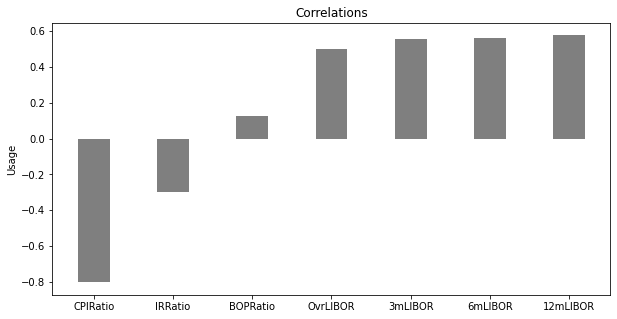

In [48]:
variables = ['CPIRatio', 'IRRatio', 'BOPRatio', 'OvrLIBOR','3mLIBOR','6mLIBOR','12mLIBOR']

forex = completeDf['ForexAvg'].tolist()
correlations = []

# For every variable in variables, it calculates the Pearsons correlation between
# FOREX and the variable
for x in range(len(variables)):
    
    column = completeDf[variables[x]].tolist()

    r = np.corrcoef(forex, column)

    correlations.append(r[0,1])

# These correlations are then displayed on a graph
y_pos = np.arange(0,14,2)
plt.figure(figsize=(10,5))
plt.bar(y_pos, correlations, align='center', alpha=0.5, color=(0.0, 0.0, 0.0, 1))
plt.xticks(y_pos, variables)
plt.ylabel('Usage')
plt.title('Correlations')
plt.show()

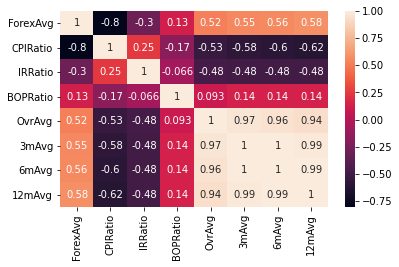

In [49]:
# This does the same as above except it calculates the correlation between all
# pairs of variables
corrDf = completeDf[['ForexAvg','CPIRatio', 'IRRatio',
                    'BOPRatio', 'OvrAvg', '3mAvg',
                    '6mAvg', '12mAvg']]

# The correlations are displayed as a matrix
corrMatrix = corrDf.corr()
sn.heatmap(corrMatrix, annot=True)
plt.gcf().subplots_adjust(bottom=0.20)
plt.savefig('CorrelationMatrix3.png')
plt.show()

# Neural Networks

## Data setup

Contains all of the parameters for the models to be trained. This is where to control what data is getting trained etc.

In [0]:
# Parameters for the neural networks
EPOCHS = 10
VALIDATION_STEPS = 50
BATCH_SIZE = 30
FOLDS = 5

# Paramters for the splitting of data
# HISTORY_STEPS is the number of past months to be included

HISTORY_STEPS = 24
# FUTURE_STEPS is the number of months in advance to be predicted
FUTURE_STEPS = 6

# Changing the value in target will decide which data the neural networks are attempting to predict
target = ['ForexAvg']
# Features is the data that will be used as inputs to the models to predict the target
# This array was changed depending on the experiment
features = ['ForexAvg']

# Gets the relevant data from the main data frame
dataSet = completeDf[features]
dataSet = dataSet.values
target = completeDf[target]
target = target.values

# Calculates the size of the folds and then determines the locations of the fold splits
fold_steps = math.floor(len(dataSet) / FOLDS)
fold_locations = []
results = []

for x in range(0,len(dataSet), fold_steps):
    fold_locations.append(x)

## Data splitting functions

In [0]:
# Function to retreive the indicies of the backdated datapoints
# it will go the number of steps passed to it in monthly increments
def getIndices(currentIndex, steps):

    indices = []

    index = currentIndex

    # Starting from the currentIndex parameter it will go back
    # 22 for 3 months and then 21 for one
    for i in range(1, steps + 1):
        if i % 4 == 0:
            indices.append(index)
            index = index - 21
        else:
            indices.append(index)
            index = index - 22

    # Reverse this list to get it moving forward again
    indices = list(reversed(indices))

    return indices

# Function to split the data into features and labels for the single-step models
def singleStepDataSplit(dataset, target, startIndex, endIndex,
                steps, future_steps):  
    features = []
    labels = []

    # Determine the start and end point using the start and end index passed to it
    history_size = 22 * steps
    max_index = 22 * future_steps
    target_size = round(21.75 * future_steps)
    startIndex = startIndex + history_size

    # If endIndex is none then use the full dataset
    if endIndex is None:
        endIndex = len(dataset) - max_index

    # Loop over each index, retreive the past indices to get the past data values
    # as the features, and go forward the size of the futureStep
    for i in range(startIndex, endIndex):
        dataIndices = getIndices(i,steps)
        features.append(dataset[dataIndices])
        labels.append(target[i+target_size])

    # Return an array of features and their respective label
    return np.array(features), np.array(labels)

# Function to retreive the indicies of the future values
def getFutureIndices(currentIndex, steps):

    indices = []
    index = currentIndex + 22

    # Starting from current index + one month, calculate indicies
    for i in range(1, steps + 1):
        if i % 4 == 0:
            indices.append(index)
            index = index + 21
        else:
            indices.append(index)
            index = index + 22

    return indices

# Function to split the data into features and labels for the multi-step models
def multiStepDataSplit(dataset, target, start_index, end_index, steps, future_steps):
    features = []
    labels = []

    history_size = 22 * steps
    target_size = 22 * future_steps

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    # For each index, retreive the past features and future labels
    for i in range(start_index, end_index):
        indices = getIndices(i,steps)
        features.append(dataset[indices])
        indiciesL = getFutureIndices(i, future_steps)
        labels.append(target[indiciesL])

    return np.array(features), np.array(labels)

## Single-step LSTM

### Building network

In [0]:
# Build single-step model consisting of one layer of 32 LSTM cells into 1 dense cell
def singleStepLSTM():
    singleStepLSTMModel = keras.Sequential([
        layers.LSTM(32, input_shape=(HISTORY_STEPS, len(features))),
        layers.Dense(1)
    ])

    # Use the 'adam' optmizer and print the mse as the loss values
    singleStepLSTMModel.compile(optimizer='adam', loss='mse')
    return singleStepLSTMModel

### Training models

In [53]:
# Function to train a set of models using history_steps as the number of time lags
# and future_step being the prediction horizon being predicted. Produces a model
# for each fold
def trainModel(history_steps, future_step):

    models = []

    # For each fold split the data and train the model, the first fold location is 0
    # so start from the second split
    for x in range(1, FOLDS):

        model = singleStepLSTM()

        # This is the index of the data that the model will train up to
        valIndex = fold_locations[x]
        
        # end index is the index the model will use to validate the data on
        if (x==FOLDS-1):
            endIndex = None
        else:
            endIndex = fold_locations[x+1]

        # Split the data into the features and labels 
        xTrain, yTrain = singleStepDataSplit(dataSet, target, 0, valIndex, history_steps, future_step)
        xVal, yVal = singleStepDataSplit(dataSet, target, valIndex, endIndex, history_steps, future_step)

        # Batch the data into the correct format to be used by the TensorFlow models
        dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
        dataTrain = dataTrain.cache().batch(BATCH_SIZE).repeat()
        dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
        dataVal = dataVal.batch(BATCH_SIZE).repeat()

        print("--------------------- Model validated on fold ", "%d/%d --------------------------" % (x, FOLDS - 1))

        # Calculate the required number of steps per epoch for the size of the dataset
        # to ensure the whole dataset is used for an epoch
        epochSteps = math.floor(len(xTrain)/BATCH_SIZE)

        # Train the model
        result = model.fit(dataTrain, epochs=EPOCHS, steps_per_epoch=epochSteps,
                            validation_data=dataVal, validation_steps=50)

        # Save the trained model to later be tested
        models.append(model)

    # Return the model for each fold, 4 models
    return models

# Function to train all folds models for each of the 6 prediction horizons for one dataset combination
def createModelsForAllSteps():

    allModels = []

    for i in range(1,FUTURE_STEPS+1):

        print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& Month", "%d/%d &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&" % (i, FUTURE_STEPS))

        models = trainModel(HISTORY_STEPS, i)
        allModels.append(models)

    # Return array of all models. Shape of (6, 4)
    return allModels

# Save all models created from the single-step training
allModels = createModelsForAllSteps()

&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& Month 1/6 &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
--------------------- Model validated on fold  1/4 --------------------------
Epoch 1/10
14/14 [==============================] - 1s 49ms/step - loss: 0.7527 - val_loss: 0.3601
Epoch 2/10
14/14 [==============================] - 0s 19ms/step - loss: 0.0774 - val_loss: 0.3895
Epoch 3/10
14/14 [==============================] - 0s 20ms/step - loss: 0.1024 - val_loss: 0.3949
Epoch 4/10
14/14 [==============================] - 0s 20ms/step - loss: 0.0654 - val_loss: 0.3508
Epoch 5/10
14/14 [==============================] - 0s 21ms/step - loss: 0.0550 - val_loss: 0.3573
Epoch 6/10
14/14 [==============================] - 0s 20ms/step - loss: 0.0558 - val_loss: 0.3741
Epoch 7/10
14/14 [==============================] - 0s 19ms/step - loss: 0.0565 - val_loss: 0.3826
Epoch 8/10
14/14 [==============================] - 0s 20ms/step - loss: 0.0563 - val_loss: 0.3894
Epoch 9/10
14/14 [==============================] - 

### Single-step tests

In [54]:
allMses = []
allClassifications = []
bestGuessClassifications = []
relaxedGuessClassifications = []

# Function to calculate 2 metrics for one model against the test data supplied
def singleStepModelTests(model, xTest, yTest):

    mses = []
    classifications = []
    correctDirection = 0

    # Calculate the MSE of the model using the unseen test data features and labels
    mse = model.evaluate(xTest,yTest)

    # For each test datapoint calculate the direction classifcation
    for x in range(len(xTest)):
        # Get the most recent FOREX value, the prediction based on the features and the actual value
        current = xTest[x][-1][0]
        past = tf.constant([xTest[x]])
        prediction = model.predict(past)[0]
        future = yTest[x]

        # If they moved in the same direction then +1 to the correct count
        if((current > prediction) == (current > future)):
                correctDirection = correctDirection + 1


    directionClass = correctDirection / len(xTest)
    mses.append(mse)
    classifications.append(directionClass)

    return mses, classifications

# Function to test all single-step models on the first two metrics
def runModels(models):

    modelMses = []
    modelClassifications = []

    # Test the model for each fold
    for i in range(1, FOLDS):

        # Get the start and end locations to get the test data for each fold
        # this would be the fold after the one they were trained on
        valIndex = fold_locations[i]
    
        if (i==FOLDS-1):
            endIndex = None
        else:
            endIndex = fold_locations[i+1]

        # Split the data into features and labels to do the testing
        xTest, yTest = singleStepDataSplit(dataSet, dataSet[:, 0], valIndex, endIndex, HISTORY_STEPS, FUTURE_STEPS)
        # Do the tests
        mses,classifications = singleStepModelTests(models[i-1], xTest, yTest)

        modelMses.append(mses)
        modelClassifications.append(classifications)

        meanMse = np.mean(modelMses)
        meanClass = np.mean(modelClassifications)

    return modelMses, modelClassifications

# Function to test a complete set of models to test the guessing ability metric for a particular fold
def bestGuessTests(models, fold):

    valIndex = fold_locations[fold+1]
    
    if (fold==FOLDS-2):
        endIndex = None
    else:
        endIndex = fold_locations[fold+2]

    correctMax = 0
    correctMaxRelaxed = 0

    # Split the data using the multi-step method as we want to get the following 6 values so a set of single-step
    # models can be tested
    xTest, yTest = multiStepDataSplit(dataSet, dataSet[:, 0], valIndex, endIndex, HISTORY_STEPS, FUTURE_STEPS)

    # For each feature vector, test the guessing ability
    for datapoint in range(len(xTest)):

    
        past = tf.constant([xTest[datapoint]])
        future = yTest[datapoint]

        predictions = []

        # Get the prediction from each of the 6 models
        for j in range(FUTURE_STEPS):

            prediction = models[j].predict(past)
            predictions.append(prediction)

        # Get the index of the highest values
        actualMax = np.argmax(future)
        predictedMax = np.argmax(predictions)

        # Get the index of the 2nd highest value
        future[actualMax] = -100000
        actual2ndMax = np.argmax(future)

        # Test if the models correctly predicted the FOREX best month or 2nd best
        if(predictedMax == actualMax):
            correctMax = correctMax + 1
            correctMaxRelaxed = correctMaxRelaxed + 1
        elif(predictedMax == actual2ndMax):
            correctMaxRelaxed = correctMaxRelaxed + 1
    
    bestMonthClass = correctMax / len(xTest)
    bestMonthRelaxedClass = correctMaxRelaxed / len(xTest)

    return bestMonthClass, bestMonthRelaxedClass

# Function to run the guessing ability metric for all models
def runBestGuessTests(allModels):

    foldPerformances = []
    relaxedFoldperformances = []

    # For each fold, test the set of single-step models for their guessing ability 
    for i in range(len(allModels[0])):

        foldModels = []

        for j in range(FUTURE_STEPS):
            foldModels.append(allModels[j][i])

        # Get the fold performance for both the best and relaxed guesses
        foldPerformance, relaxedFoldperformance = bestGuessTests(foldModels, i)

        foldPerformances.append(foldPerformance)
        relaxedFoldperformances.append(relaxedFoldperformance)

    return foldPerformances, relaxedFoldperformances

# Function to run all tests for all single-step models
def singleStepExperiments():
    
    for modelsForOneStep in allModels:

        modelMses, modelClassifications = runModels(modelsForOneStep)
        allMses.append(modelMses)
        allClassifications.append(modelClassifications)

    bestGuess, relaxedGuess = runBestGuessTests(allModels)

    bestGuessClassifications.append(bestGuess)
    relaxedGuessClassifications.append(relaxedGuess)

singleStepExperiments()

10/10 [==============================] - 0s 3ms/step - loss: 0.0789


### Results

In [0]:
# Simple function to display the results from the single-step models
def printResults(mses,directionClass,bestClass):

    for i in range(FUTURE_STEPS):

        print("-----------")
        print("Month " + str((i+1)))
        print("MSE: " + str(mses[i]))
        print("Dir: " + str(directionClass[i]))

    print("---------")
    print("Bes: " + str(bestClass))

### Prediction visualisation

In [0]:
# Functions to display real vs predicted values on a graph
def create_time_steps(length,steps):
    return list(np.arange(-length, 0,step=steps))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(TIME_LAGS,STEP)

    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                    label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

## Multi-step LSTM

### Building network

In [0]:
# Creating the multi-step model consisting of two layers of LSTM cells
def multiStepLSTM():
    multiStepLSTMModel = keras.Sequential([
        layers.LSTM(units=32, return_sequences=True, input_shape = (HISTORY_STEPS, len(features))),
        layers.LSTM(16, activation='relu'),
        layers.Dense(FUTURE_STEPS)
    ])

    multiStepLSTMModel.compile(optimizer='adam', loss='mse')
    return multiStepLSTMModel

multiStepModel = multiStepLSTM()

### Training models

In [58]:
models = []
results = []
dataTrainMulti = []

# Train a model for each time period fold 
for x in range(1, FOLDS):

    # Get the start and end indices of the data to be traied on
    valIndex = fold_locations[x]

    multiStepModel = multiStepLSTM()
    
    if (x==FOLDS-1):
        endIndex = None
    else:
        endIndex = fold_locations[x+1]

    # Get the features and labels for both training and validation data
    xTrainMulti, yTrainMulti = multiStepDataSplit(dataSet, target, 0, valIndex, HISTORY_STEPS, FUTURE_STEPS)
    xValMulti, yValMulti = multiStepDataSplit(dataSet, target, valIndex, endIndex, HISTORY_STEPS, FUTURE_STEPS)

    # Batch data into the correct format
    dataTrainMulti = tf.data.Dataset.from_tensor_slices((xTrainMulti, yTrainMulti))
    dataTrainMulti = dataTrainMulti.cache().batch(BATCH_SIZE).repeat()
    dataValMulti = tf.data.Dataset.from_tensor_slices((xValMulti, yValMulti))
    dataValMulti = dataValMulti.batch(BATCH_SIZE).repeat()

    print("--------------------- Model", "%d/%d --------------------------" % (x, FOLDS - 1))

    steps_per = math.floor(len(xTrainMulti)/BATCH_SIZE)

    # Train the models
    result = multiStepModel.fit(dataTrainMulti, epochs=EPOCHS, steps_per_epoch=steps_per,
                        validation_data=dataValMulti, validation_steps=50)
    
    models.append(multiStepModel)
    results.append(result)

--------------------- Model 1/4 --------------------------
Epoch 1/10
14/14 [==============================] - 1s 67ms/step - loss: 0.8047 - val_loss: 0.5245
Epoch 2/10
14/14 [==============================] - 0s 33ms/step - loss: 0.5945 - val_loss: 0.5395
Epoch 3/10
14/14 [==============================] - 0s 34ms/step - loss: 0.4803 - val_loss: 0.4172
Epoch 4/10
14/14 [==============================] - 0s 33ms/step - loss: 0.2824 - val_loss: 0.4616
Epoch 5/10
14/14 [==============================] - 0s 33ms/step - loss: 0.2103 - val_loss: 0.4888
Epoch 6/10
14/14 [==============================] - 0s 35ms/step - loss: 0.1111 - val_loss: 0.5469
Epoch 7/10
14/14 [==============================] - 0s 33ms/step - loss: 0.0811 - val_loss: 0.5472
Epoch 8/10
14/14 [==============================] - 0s 34ms/step - loss: 0.0624 - val_loss: 0.6072
Epoch 9/10
14/14 [==============================] - 1s 38ms/step - loss: 0.0554 - val_loss: 0.6332
Epoch 10/10
14/14 [==============================]

### Multi-step tests

In [0]:
allMsesMulti = []
allClassificationsMulti = []
bestGuessClassificationsMulti = []
relaxedGuessClassificationsMulti = []

# Function to test a single model all three metrics
def multiStepModelTests(model, xTest, yTest):

    # Array of numbers, one for each month, to be used to seperate the performance for each month
    correctDirection = [0,0,0,0,0,0]
    totalSquaredError = [0,0,0,0,0,0]

    correctMax = 0
    correctMaxRelaxed = 0

    noDatapoints = len(xTest)

    # For each test datapoint, run all tests
    for x in range(noDatapoints):
        # Get the current (most recent) FOREX value
        current = xTest[x][-1][0]
        # Get the past values that are passed into the model
        past = tf.constant([xTest[x]])
        # Make the predictions
        predictions = model.predict(past)[0]
        # The actual future values
        future = yTest[x]

        # Calculate if the predicted best month or 2nd best month
        predictedMax = np.argmax(predictions)
        actualMax = np.argmax(future)

        temp = future[actualMax]
        future[actualMax] = -100000
        actual2ndMax = np.argmax(future)

        if(predictedMax == actualMax):
            correctMax = correctMax + 1
            correctMaxRelaxed = correctMaxRelaxed + 1
        elif(predictedMax == actual2ndMax):
            correctMaxRelaxed = correctMaxRelaxed + 1

        future[actualMax]=temp

        # Calculate MSE value for each months predictions 
        for y in range(FUTURE_STEPS):
            prediction = predictions[y]
            actual = future[y]

            squaredDifference = abs(prediction - actual) ** 2
            totalSquaredError[y] = totalSquaredError[y] + squaredDifference

            if ((current > prediction) == (current > actual)):
                correctDirection[y] = correctDirection[y] + 1


    mses = []
    classifications = []

    # Calculate average mse and direction classifcation rates
    for x in range(FUTURE_STEPS):
        mse = totalSquaredError[x] / noDatapoints
        mses.append(mse)

    for x in range(FUTURE_STEPS):
        monthClassification = correctDirection[x] / noDatapoints
        classifications.append(monthClassification)

    bestMonthClass = correctMax / noDatapoints
    bestMonthRelaxedClass = correctMaxRelaxed / noDatapoints

    allMsesMulti.append(mses)
    allClassificationsMulti.append(classifications)
    bestGuessClassificationsMulti.append(bestMonthClass)
    relaxedGuessClassificationsMulti.append(bestMonthRelaxedClass)


# Function to run tests on all multi-step models
def runModels(models):

    modelMses = []
    modelClassifications = []

    for i in range(1, FOLDS):

        valIndex = fold_locations[i]
    
        if (i==FOLDS-1):
            endIndex = None
        else:
            endIndex = fold_locations[i+1]

        xTestMulti, yTestMulti = multiStepDataSplit(dataSet, dataSet[:, 0], valIndex, endIndex, HISTORY_STEPS, FUTURE_STEPS)

        # Run tests for fold model
        multiStepModelTests(models[i-1], xTestMulti, yTestMulti)

runModels(models)

In [0]:
# Reshape results
allMsesMulti = list(map(list, zip(*allMsesMulti)))
allClassificationsMulti = list(map(list, zip(*allClassificationsMulti)))

### Results

Small code when wanting to see the results before being exported

In [0]:
# Simple function to display results
def printResults(monthAverageMses,monthAverageClass,bestClass):

    for i in range(len(monthAverageMses)):

        print("-----------")
        print("Month " + str((i+1)))
        print("MSE: " + str(monthAverageMses[i]))
        print("Dir: " + str(monthAverageClass[i]))

    print("---------")
    print("Bes: " + str(bestClass))

### Prediction visualisation

In [0]:
# Function to be used if wanting visualisation of predictions vs real values
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(TIME_LAGS,STEP)
  num_out = len(true_future) * FUTURE_STEP

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out, step=FUTURE_STEP), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out,step=FUTURE_STEP), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

# Exporting Results

This code was for the exporting of all results into a single Google sheet

In [63]:
!pip install --upgrade -q pygsheets

import google.auth
from google.colab import auth
import pygsheets

# Authenticate access to the Google sheet
auth.authenticate_user()
credentials, _ = google.auth.default()
gc = pygsheets.client.Client(credentials)

# Open and create a new worksheet
sh = gc.open('Results')
sh.add_worksheet('FOREX') 

wk1 = sh[0]

shiftSize = FUTURE_STEPS + 5

# Insert the titles for each of the results to be added so a human can read it
titles = ['SINGLE_STEP','MSE(Fold1)','MSE(Fold2)','MSE(Fold3)','MSE(Fold4)','MSE(avg)',
          'Dir(Fold1)','Dir(Fold2)','Dir(Fold3)','Dir(Fold4)','Dir(avg)']

wk1.insert_rows(row = 0, number = 0, values = titles) 

mseAvgsSingle = []
dirAvgsSingle = []
bestSingle = []
relaxedSingle = []

mseAvgsMulti = []
dirAvgsMulti = []
bestMulti = []
relaxedMultti = []

# Add the MSE and direction results for the single-step models
for step in range(FUTURE_STEPS):

    row = []

    month = 'Month ' + str(step+1)

    row.append(month)
    
    # Get the 4 MSE fold results for the month
    for fold in range(FOLDS-1):
        row.append(str(allMses[step][fold][0]))

    arr = np.asarray(allMses[step])
    mean = np.mean(arr)
    row.append(mean)
    mseAvgsSingle.append(mean)

    # Ge the 4 direction results for the month
    for fold in range(FOLDS-1):
        row.append(str(allClassifications[step][fold][0]))

    arr = np.asarray(allClassifications[step])
    mean = np.mean(arr)
    row.append(str(mean))
    dirAvgsSingle.append(mean)

    # Insert month results
    wk1.insert_rows(row = step+1, number = 1, values = row)


# Add the titles again for the multi-step results
guessTitles = ['','Best(Fold1)','Best(Fold2)','Best(Fold3)','Best(Fold4)','Best(avg)',
               'Relaxed(Fold1)','Relaxed(Fold2)','Relaxed(Fold3)','Relaxed(Fold4)','Relaxed(avg)']

wk1.insert_rows(row = FUTURE_STEPS+2, number = 1, values = guessTitles)

guessResults = ['']

# Add the best guess single-step results
for fold in range(len(bestGuessClassificationsMulti)):
    classification = bestGuessClassifications[0][fold]
    guessResults.append(classification)

arr = np.asarray(bestGuessClassifications[0])
mean = np.mean(arr)
guessResults.append(str(mean))
bestSingle = mean

# Add the relaxed guess single-step results
for fold in range(len(bestGuessClassificationsMulti)):
    classification = relaxedGuessClassifications[0][fold]
    guessResults.append(classification)

arr = np.asarray(relaxedGuessClassifications[0])
mean = np.mean(arr)
guessResults.append(str(mean))
relaxedSingle = mean
wk1.insert_rows(row = FUTURE_STEPS+3, number = 1, values = guessResults)


titles[0] = 'MULTI-STEP'
# Insert titles for multi-step test results
wk1.insert_rows(row = shiftSize, number = 0, values = titles)

# Add the MSE and direction results for each month
for step in range(FUTURE_STEPS):

    row = []

    month = 'Month ' + str(step+1)

    row.append(month)
    
    # Add the fold MSE results and average
    for fold in range(FOLDS-1):
        row.append(str(allMsesMulti[step][fold]))

    arr = np.asarray(allMsesMulti[step])
    mean = np.mean(arr)
    row.append(mean)
    mseAvgsMulti.append(mean)

    # Add the fold direction results to the row and average
    for fold in range(FOLDS-1):
        row.append(str(allClassificationsMulti[step][fold]))

    arr = np.asarray(allClassificationsMulti[step])
    mean = np.mean(arr)
    row.append(str(mean))
    dirAvgsMulti.append(mean)

    # Insert row
    wk1.insert_rows(row = shiftSize+step+1, number = 1, values = row)

guessTitles = ['','Best(Fold1)','Best(Fold2)','Best(Fold3)','Best(Fold4)','Best(avg)',
               'Relaxed(Fold1)','Relaxed(Fold2)','Relaxed(Fold3)','Relaxed(Fold4)','Relaxed(avg)']

wk1.insert_rows(row = shiftSize+FUTURE_STEPS+2, number = 1, values = guessTitles)

guessResults = ['']

# Get the best guess classification results
for fold in range(len(bestGuessClassificationsMulti)):
    classification = bestGuessClassificationsMulti[fold]
    guessResults.append(classification)

# Average the resuls and add to the row to be added
arr = np.asarray(bestGuessClassificationsMulti)
mean = np.mean(arr)
guessResults.append(str(mean))
bestMulti = mean

# Get the relaxed guess classification results
for fold in range(len(bestGuessClassificationsMulti)):
    classification = relaxedGuessClassificationsMulti[fold]
    guessResults.append(classification)

# Average the results and add to the row to be added
arr = np.asarray(relaxedGuessClassificationsMulti)
mean = np.mean(arr)
guessResults.append(str(mean))
relaxedMulti = mean
# Insert row
wk1.insert_rows(row = shiftSize+FUTURE_STEPS+3, number = 1, values = guessResults)

# Create a small summary table for all results including the average resuls for each metric
# for each motnh
for i in range(FUTURE_STEPS):

    # Get MSE and direction average for each month for each model and insert row
    month = 'Month ' + str(i+1)
    row = [month]
    row.append(str(mseAvgsSingle[i]))
    row.append(str(dirAvgsSingle[i]))
    row.append(str(mseAvgsMulti[i]))
    row.append(str(dirAvgsMulti[i]))

    wk1.insert_rows(row = shiftSize+FUTURE_STEPS+i+7, number = 1, values = row)

# Get the guessing ability averages for both model and insert row 
row = ['Guesses']
row.append(str(bestSingle))
row.append(str(relaxedSingle))
row.append(str(bestMulti))
row.append(str(relaxedMulti))

wk1.insert_rows(row = shiftSize+FUTURE_STEPS+FUTURE_STEPS+7, number = 1, values = row)

SpreadsheetNotFound: ignored

# Visualising Results


## Importing Results

Imports all the results from the worksheet

In [0]:
!pip install --upgrade -q pygsheets

import google.auth
from google.colab import auth
import pygsheets
import matplotlib as mpl
import matplotlib.pyplot as plt

msesSingleAll = []
msesMultiAll = []
dirSingleAll = []
dirMultiAll = []
bestGuessSingle = []
bestGuessMulti = []
relaxedGuessSingle = []
relaxedGuessMulti = []

titles = ['ARIMA','Forex','ForexAvg','CPI','IR','BOP','OVR','OVRAvg','3m','3mAvg','6m','6mAvg','12m','12mAvg','CPI,IR','CPI,BOP','CPI,3m','IR,BOP','IR,3m','BOP,3m']

# Function to import the results of one worksheet
def importWorksheet(index):

    # Authenticate access to the google sheet
    auth.authenticate_user()
    credentials, _ = google.auth.default()
    gc = pygsheets.client.Client(credentials)

    sh = gc.open('Results')

    wk1 = sh[index]

    # Row number of start of summary results
    summaryRow = 25

    msesSingle = []
    msesMulti = []
    dirSingle = []
    dirMulti = []
    guesses = []

    # Get each months MSE and direction results
    for i in range(FUTURE_STEPS):

        row = wk1.get_row(summaryRow)

        msesSingle.append(float(row[1]))
        dirSingle.append(float(row[2]))

        if(index!=0):
            msesMulti.append(float(row[3]))
            dirMulti.append(float(row[4]))
        else:
            msesMulti.append(0)
            dirMulti.append(0)

        summaryRow = summaryRow + 1

    guesses = wk1.get_row(summaryRow)

    bestGuessSingle.append(float(guesses[1]))
    relaxedGuessSingle.append(float(guesses[2]))

    # If index is 0 then it is the ARIMA results and so only has one set of results
    if(index!=0):
        bestGuessMulti.append(float(guesses[3]))
        relaxedGuessMulti.append(float(guesses[4]))
    else:
        bestGuessMulti.append(0)
        relaxedGuessMulti.append(0)

    msesSingleAll.append(msesSingle)
    msesMultiAll.append(msesMulti)
    dirSingleAll.append(dirSingle)
    dirMultiAll.append(dirMulti)


worksheetIndices = range(len(titles))

# Function to import all worksheets (all datasets)
def importAllWorksheets():
    for index in worksheetIndices:
        importWorksheet(index)


importAllWorksheets()

## Create Graphs

This was code to produce graphs for the dissertation

In [0]:
months = [1,2,3,4,5,6]

# Display the results of data which has a result for each month
# This can be fed both MSE and direction data
def monthGraph(data, labels, xLabel, yLabel, title):

    x = months

    for i in range(len(data)):

        y1 = data[i]
        
        plt.plot(x, y1, label = labels[i])

    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.legend()
    plt.savefig('mse2.png')
    plt.show()

# Function to produce bar chart, seperating single and multi-step
def guessBarChart(data1, data2, labels, title, threshold):

    x = np.arange(len(labels))
    width = 0.35 

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, data1, width, label='Single-Step')
    rects2 = ax.bar(x + width/2, data2, width, label='Multi-step')
    ax.plot([-0.35, 7.35], [threshold, threshold], "k--")
    ax.set_ylabel('Classification')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

# Function to produce bar chart, seperating best and relaxed guess
def guessBarChart1(data1, data2, labels, title, threshold):

    x = np.arange(len(labels))
    width = 0.35 

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, data1, width, label='Best Guess')
    rects2 = ax.bar(x + width/2, data2, width, label='Relaxed Guess')
    ax.plot([-0.35, 6.35], [(1/6), (1/6)], "k--")
    ax.plot([-0.35, 6.35], [(1/3), (1/3)], "k--")
    ax.set_ylabel('Classification')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.savefig('guess.png')

# Function used to get the data ready to be put it in a line graph
def getLineData(mseSingleIndices,msesMultiIndices,dirSingleIndices,
                dirMultiIndices,labels, xLabel, yLabel, title):

    data = []

    for x in mseSingleIndices:
        data.append(msesSingleAll[x])
    for x in msesMultiIndices:
        data.append(msesMultiAll[x])
    for x in dirSingleIndices:
        data.append(dirSingleAll[x])
    for x in dirMultiIndices:
        data.append(dirMultiAll[x])
    

    monthGraph(data,labels,xLabel,yLabel,title)

# Function used to get the data ready to be put into a bar chart
def getBarData(singleIndices, multiIndices, labels):

    bestGuess = []
    relaxedGuess = []

    for x in singleIndices:
        bestGuess.append(bestGuessSingle[x])
    for x in multiIndices:
        bestGuess.append(bestGuessMulti[x])
    for x in singleIndices:
        relaxedGuess.append(relaxedGuessSingle[x])
    for x in multiIndices:
        relaxedGuess.append(relaxedGuessMulti[x])

    guessBarChart1(bestGuess, relaxedGuess, labels,'', 0)


# Function to create line graph for single dataset passed to it
def createMonthGraphs(indices, data, xLabel, yLabel, title):

    data = [data[x] for x in indices]
    labels = [titles[x] for x in indices]

    monthGraph(data, labels,'Months','MSE',title)


# Function to create line graphs for all dataset indices passed to it
def createAllMonthGraphs(indices):

    createMonthGraphs(indices, msesSingleAll, 'Months', 'MSE','Single-step MSE')
    createMonthGraphs(indices, msesMultiAll, 'Months', 'MSE','Multi-step MSE')

    createMonthGraphs(indices, dirSingleAll, 'Months', 'Classification', 'Single-step Direction Classification')
    createMonthGraphs(indices, dirMultiAll, 'Months', 'Classification', 'Multi-step Direction Classification')

# Function to create bar charts for all dataset indicies passed to it
def createBarCharts(indices):

    labels = [titles[x] for x in indices]
    data1 = [bestGuessSingle[x] for x in indices]
    data2 = [bestGuessMulti[x] for x in indices]
    data3 = [relaxedGuessSingle[x] for x in indices]
    data4 = [relaxedGuessMulti[x] for x in indices]

    guessBarChart1(data1, data3, labels,'Single-step month Classification', (1/6))
    guessBarChart1(data2, data4, labels,'Multi-step month Classification', (1/3))

# Set of indicies for economic data being tested by themselves
#indicies = [2,3,4,5,7,9,11,13]
# Set of indicies for tests using multiple datasets
#indicies = [2,14,15,16,17,18,19]

createAllMonthGraphs(indices)    
createBarCharts(indices)

# ARIMA

The following code is was for the testing and development of the ARIMA models

In [0]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

xValues, yValues = multiStepDataSplit(dataSet, target, 3500, None, 40, FUTURE_STEPS)

mses = []

# Function to test the results of one set of ARIMA parameters
def mseARIMAmodel(p,q,d):

    tmse = 0

    for x in range(len(xValues)):
        current = xValues[x][-1][0]
        past = xValues[x]
        future = yValues[x]

        model = ARIMA(past, order=(p,q,d))
        model_fit = model.fit(disp=0)
        predictions = model_fit.forecast(steps=FUTURE_STEPS)[0]

        error = mean_squared_error(future,predictions)
        tmse = tmse + error

    mse = tmse / len(xValues)
    mses.append(mse)


# Function to test different combinations of ARIMA parameters
def tuneParamters():
    p_values = [4, 6, 8, 10]
    d = 1
    q = 0

    for p in p_values:
        mseARIMAmodel(p,d,q)


tuneParamters()

In [0]:
arimaMSES = []
arimaDir = []
arimaBestGuess = []
arimaRelaxedGuess = []

xValues, yValues = multiStepDataSplit(dataSet, target, 950, None, 40, FUTURE_STEPS)

# Function to complete full tests for the ARIMA model
def testARIMA():

    correctDirection = [0,0,0,0,0,0]
    totalSquaredError = [0,0,0,0,0,0]
    correctMax = 0
    correctMaxRelaxed = 0

    # For each test datapoint calculate metrics
    for x in range(len(xValues)):
        current = xValues[x][-1][0]
        past = xValues[x]
        future = yValues[x]

        # Get ARIMA model predictions
        model = ARIMA(past, order=(6,1,0))
        model_fit = model.fit(disp=0)
        predictions = model_fit.forecast(steps=FUTURE_STEPS)[0]

        # Test for best and relaxed month guessing ability
        predictedMax = np.argmax(predictions)
        actualMax = np.argmax(future)

        temp = future[actualMax][0]
        future[actualMax] = -100000
        actual2ndMax = np.argmax(future)

        if(predictedMax == actualMax):
            correctMax = correctMax + 1
            correctMaxRelaxed = correctMaxRelaxed + 1
        elif(predictedMax == actual2ndMax):
            correctMaxRelaxed = correctMaxRelaxed + 1
        future[actualMax]=temp

        # Calculate MSE for each month
        for y in range(FUTURE_STEPS):
            prediction = predictions[y]
            actual = future[y]

            squaredDifference = abs(prediction - actual) ** 2
            totalSquaredError[y] = totalSquaredError[y] + squaredDifference

            if ((current > prediction) == (current > actual)):
                correctDirection[y] = correctDirection[y] + 1

    mses = []
    classifications = []

    # Calculate the average results across all test data points
    for x in range(FUTURE_STEPS):
        mse = totalSquaredError[x] / len(xValues)
        arimaMSES.append(mse)

    for x in range(FUTURE_STEPS):
        percentInterval = correctDirection[x] / len(xValues)
        arimaDir.append(percentInterval)

    bestMonthClass = correctMax / len(xValues)
    bestMonthRelaxedClass = correctMaxRelaxed / len(xValues)

    arimaBestGuess.append(bestMonthClass)
    arimaRelaxedGuess.append(bestMonthRelaxedClass)

testARIMA()